# MacArthur Commons Apartment Pricing Analysis

Analysis of rental pricing trends for **Jr. 1 Bedroom B** units (563-610 sq ft, 1 bed/1 bath)

In [1]:
import os
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configuration
SNAP_DIR = "snapshots"
TIME_FMT = "%Y%m%dT%H%M%SZ"
TARGET_FLOORPLAN = "Jr. 1 Bedroom B"  # Change this to analyze a different unit type

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load All Snapshots

In [2]:
def load_all_snapshots(dirpath):
    """Load all snapshots into a flat list of records."""
    files = sorted(
        fn for fn in os.listdir(dirpath)
        if fn.startswith("snapshot_") and fn.endswith(".json")
    )
    
    records = []
    for fn in files:
        path = os.path.join(dirpath, fn)
        with open(path) as f:
            doc = json.load(f)
        
        ts = datetime.strptime(doc["timestamp"], TIME_FMT)
        
        for apt_num, unit in doc["units"].items():
            records.append({
                "date": ts.date(),
                "timestamp": ts,
                "apartment": apt_num,
                "floorplan": unit.get("floorplan_title", ""),
                "bedrooms": int(unit.get("bedrooms", 0)),
                "bathrooms": int(unit.get("bathrooms", 0)),
                "sqft": int(unit.get("square_feet", 0)),
                "building": unit.get("building", ""),
                "rent_min": int(unit.get("rent_min", 0)),
                "rent_max": int(unit.get("rent_max", 0)),
                "price_display": unit.get("price_display", ""),
                "available_display": unit.get("available_display", ""),
            })
    
    return pd.DataFrame(records)

# Load data
df = load_all_snapshots(SNAP_DIR)
print(f"Loaded {len(df):,} records from {df['date'].nunique()} snapshots")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nUnique floorplans: {df['floorplan'].unique()}")

Loaded 1,157 records from 156 snapshots
Date range: 2025-07-14 to 2026-01-20

Unique floorplans: ['Jr. 1 Bedroom B']


## 2. Overview of All Units

In [3]:
# Summary by floorplan type
latest_date = df['date'].max()
latest_df = df[df['date'] == latest_date]

print(f"Current snapshot ({latest_date}):")
print("="*60)

summary = latest_df.groupby('floorplan').agg({
    'apartment': 'count',
    'rent_min': ['min', 'mean', 'max'],
    'sqft': 'first'
}).round(0)
summary.columns = ['Units Available', 'Min Rent', 'Avg Rent', 'Max Rent', 'Sq Ft']
print(summary.to_string())

Current snapshot (2026-01-20):
                 Units Available  Min Rent  Avg Rent  Max Rent  Sq Ft
floorplan                                                            
Jr. 1 Bedroom B                9      2126    2224.0      2374    577


## 3. Jr. 1 Bedroom B Analysis

In [4]:
# Filter to target floorplan
target_df = df[df['floorplan'] == TARGET_FLOORPLAN].copy()
print(f"Analyzing {TARGET_FLOORPLAN} units")
print(f"Total records: {len(target_df):,}")
print(f"Unique apartments seen: {target_df['apartment'].nunique()}")

Analyzing Jr. 1 Bedroom B units
Total records: 1,157
Unique apartments seen: 37


### 3.1 Price Trends Over Time

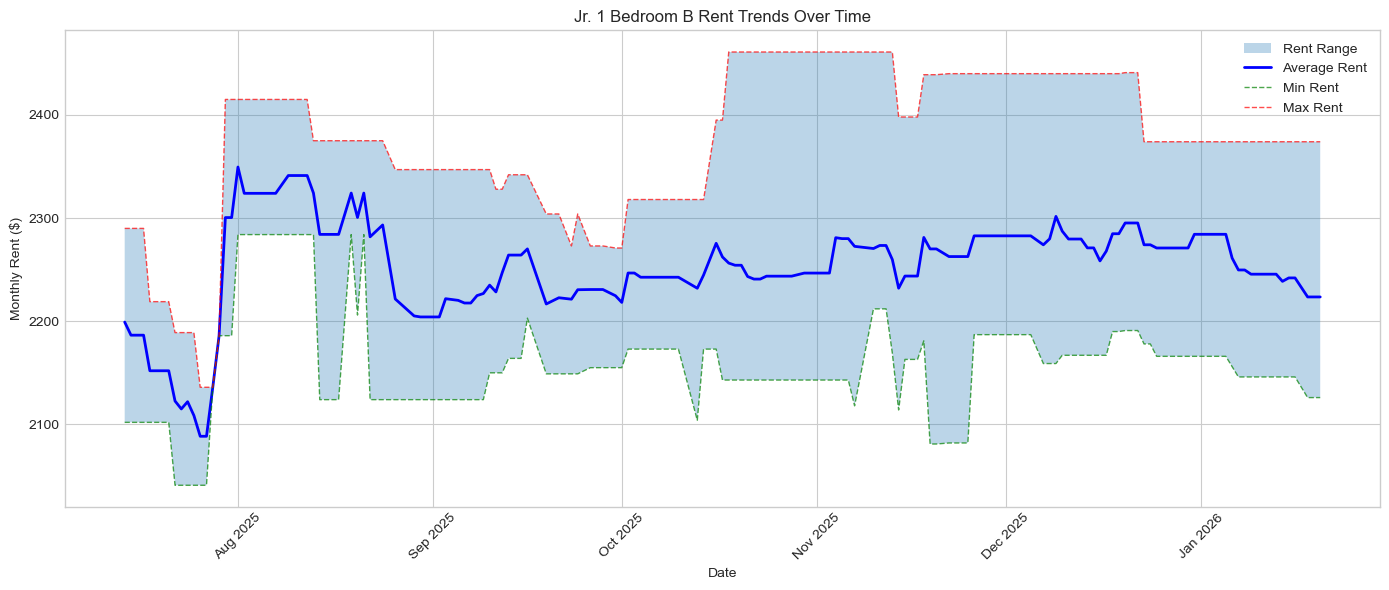


Price Statistics for Jr. 1 Bedroom B:
  Overall min rent seen: $2,041
  Overall max rent seen: $2,461
  Average rent (all time): $2,251
  Current avg rent: $2,224


In [5]:
# Aggregate daily stats
daily_stats = target_df.groupby('date').agg({
    'rent_min': ['min', 'mean', 'max', 'count'],
    'apartment': lambda x: list(x.unique())
}).reset_index()
daily_stats.columns = ['date', 'min_rent', 'avg_rent', 'max_rent', 'units_available', 'apartments']

# Plot price trends
fig, ax = plt.subplots(figsize=(14, 6))

ax.fill_between(daily_stats['date'], daily_stats['min_rent'], daily_stats['max_rent'], 
                alpha=0.3, label='Rent Range')
ax.plot(daily_stats['date'], daily_stats['avg_rent'], 'b-', linewidth=2, label='Average Rent')
ax.plot(daily_stats['date'], daily_stats['min_rent'], 'g--', linewidth=1, alpha=0.7, label='Min Rent')
ax.plot(daily_stats['date'], daily_stats['max_rent'], 'r--', linewidth=1, alpha=0.7, label='Max Rent')

ax.set_xlabel('Date')
ax.set_ylabel('Monthly Rent ($)')
ax.set_title(f'{TARGET_FLOORPLAN} Rent Trends Over Time')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Stats summary
print(f"\nPrice Statistics for {TARGET_FLOORPLAN}:")
print(f"  Overall min rent seen: ${daily_stats['min_rent'].min():,.0f}")
print(f"  Overall max rent seen: ${daily_stats['max_rent'].max():,.0f}")
print(f"  Average rent (all time): ${daily_stats['avg_rent'].mean():,.0f}")
print(f"  Current avg rent: ${daily_stats.iloc[-1]['avg_rent']:,.0f}")

### 3.2 Unit Availability Over Time

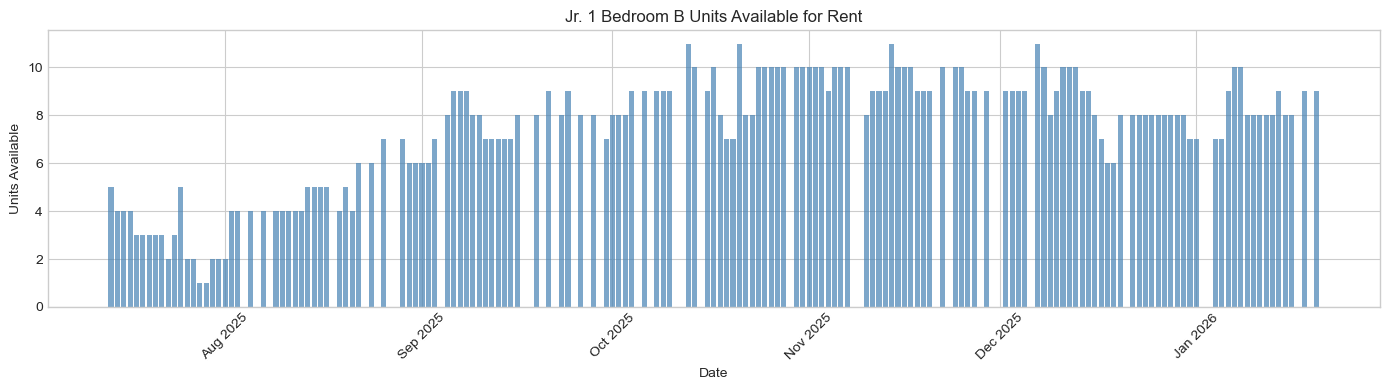

Avg units available: 7.4
Max units available: 11
Min units available: 1


In [6]:
# Plot availability
fig, ax = plt.subplots(figsize=(14, 4))
ax.bar(daily_stats['date'], daily_stats['units_available'], color='steelblue', alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Units Available')
ax.set_title(f'{TARGET_FLOORPLAN} Units Available for Rent')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Avg units available: {daily_stats['units_available'].mean():.1f}")
print(f"Max units available: {daily_stats['units_available'].max()}")
print(f"Min units available: {daily_stats['units_available'].min()}")

### 3.3 Individual Unit Price History

In [7]:
# Show units with longest listing history (still available or recently rented)
unit_days = target_df.groupby('apartment')['date'].agg(['min', 'max', 'count'])
unit_days['days_listed'] = unit_days.apply(lambda row: (row['max'] - row['min']).days, axis=1)
unit_days = unit_days.sort_values('days_listed', ascending=False)

print("Top 10 longest-listed units:")
print(unit_days.head(10).to_string())

Top 10 longest-listed units:
                  min         max  count  days_listed
apartment                                            
454        2025-08-02  2026-01-20     92          171
409        2025-07-14  2025-11-14     78          123
268        2025-10-01  2026-01-20     65          111
554        2025-08-22  2025-12-08     77          108
568        2025-10-13  2026-01-20     80           99
668        2025-10-18  2026-01-08     65           82
570        2025-11-14  2026-01-20     57           67
662        2025-11-14  2026-01-20     53           67
664        2025-11-18  2026-01-20     53           63
225        2025-09-21  2025-11-17     44           57


In [8]:
# Track a specific unit's price history
def track_unit(apt_number):
    unit_history = target_df[target_df['apartment'] == apt_number].sort_values('date')
    if unit_history.empty:
        print(f"Unit {apt_number} not found in {TARGET_FLOORPLAN} listings")
        return None
    
    print(f"\nUnit #{apt_number} Price History:")
    print(f"  Building: {unit_history.iloc[0]['building']}")
    print(f"  First seen: {unit_history['date'].min()}")
    print(f"  Last seen: {unit_history['date'].max()}")
    print(f"  Days on market: {(unit_history['date'].max() - unit_history['date'].min()).days}")
    
    # Price changes
    price_changes = unit_history[['date', 'rent_min', 'price_display']].drop_duplicates(subset=['rent_min'])
    print(f"\n  Price changes ({len(price_changes)}):")
    for _, row in price_changes.iterrows():
        print(f"    {row['date']}: ${row['rent_min']:,}")
    
    return unit_history

# Example: track a long-listed unit
if len(unit_days) > 0:
    example_unit = unit_days.index[0]
    track_unit(example_unit)


Unit #454 Price History:
  Building: A1
  First seen: 2025-08-02
  Last seen: 2026-01-20
  Days on market: 171

  Price changes (18):
    2025-08-02: $2,306
    2025-08-09: $2,375
    2025-08-26: $2,211
    2025-08-29: $2,226
    2025-09-11: $2,292
    2025-09-13: $2,225
    2025-09-19: $2,182
    2025-10-02: $2,257
    2025-10-16: $2,331
    2025-10-21: $2,234
    2025-11-04: $2,310
    2025-11-10: $2,253
    2025-11-13: $2,186
    2025-11-14: $2,181
    2025-11-19: $2,081
    2025-11-22: $2,082
    2026-01-14: $2,183
    2026-01-18: $2,133


### 3.4 Price Comparison by Building

Price by Building (Jr. 1 Bedroom B):
          Min Rent  Avg Rent  Max Rent  Unique Units
building                                            
A2            2104    2183.0      2307            10
A1            2041    2267.0      2461            20
C             2163    2286.0      2415             7


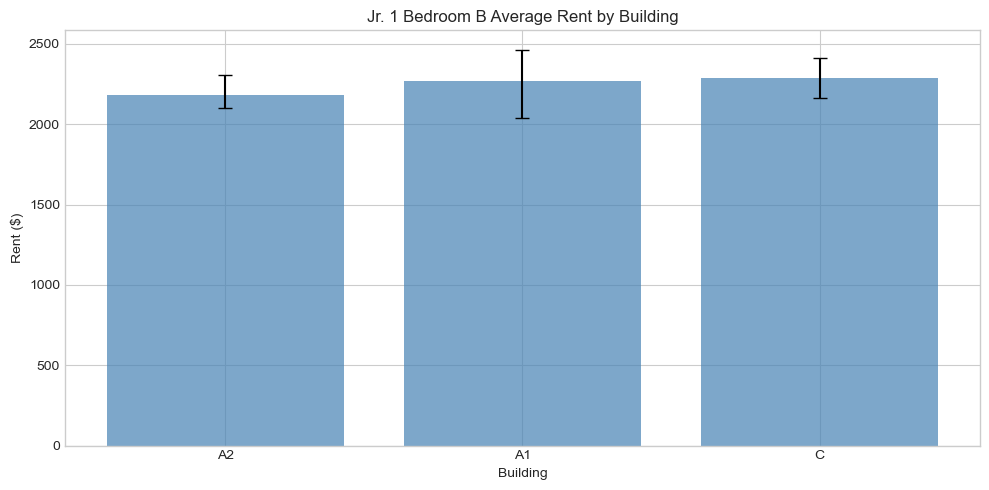

In [9]:
# Compare prices by building
building_stats = target_df.groupby('building').agg({
    'rent_min': ['min', 'mean', 'max'],
    'apartment': 'nunique'
}).round(0)
building_stats.columns = ['Min Rent', 'Avg Rent', 'Max Rent', 'Unique Units']
building_stats = building_stats.sort_values('Avg Rent')

print(f"Price by Building ({TARGET_FLOORPLAN}):")
print(building_stats.to_string())

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))
buildings = building_stats.index
x = range(len(buildings))
ax.bar(x, building_stats['Avg Rent'], color='steelblue', alpha=0.7)
ax.errorbar(x, building_stats['Avg Rent'], 
            yerr=[building_stats['Avg Rent'] - building_stats['Min Rent'],
                  building_stats['Max Rent'] - building_stats['Avg Rent']],
            fmt='none', color='black', capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(buildings)
ax.set_xlabel('Building')
ax.set_ylabel('Rent ($)')
ax.set_title(f'{TARGET_FLOORPLAN} Average Rent by Building')
plt.tight_layout()
plt.show()

## 4. Units That Got Rented

In [10]:
# Find units that disappeared (likely rented)
first_date = target_df['date'].min()
last_date = target_df['date'].max()

# Units seen at some point but not in the latest snapshot
all_units = set(target_df['apartment'].unique())
current_units = set(target_df[target_df['date'] == last_date]['apartment'].unique())
rented_units = all_units - current_units

print(f"Units likely rented (no longer listed): {len(rented_units)}")
print(f"Units still available: {len(current_units)}")

# Details on rented units
if rented_units:
    print(f"\nRented Units Summary:")
    print(f"{'Apt':<6} {'Building':<10} {'Last Rent':<12} {'Last Seen':<12} {'Days Listed'}")
    print("-" * 55)
    
    for apt in sorted(rented_units, key=lambda x: int(x) if x.isdigit() else x):
        unit_data = target_df[target_df['apartment'] == apt].sort_values('date')
        last_row = unit_data.iloc[-1]
        first_date_unit = unit_data['date'].min()
        last_date_unit = unit_data['date'].max()
        days = (last_date_unit - first_date_unit).days
        print(f"{apt:<6} {last_row['building']:<10} ${last_row['rent_min']:<10,} {str(last_date_unit):<12} {days}")

Units likely rented (no longer listed): 28
Units still available: 9

Rented Units Summary:
Apt    Building   Last Rent    Last Seen    Days Listed
-------------------------------------------------------
205    C          $2,239      2025-10-21   5
221    C          $2,250      2025-07-14   0
224    A2         $2,118      2025-11-07   21
225    C          $2,163      2025-11-17   57
244    A2         $2,104      2025-10-13   0
253    A1         $2,273      2025-09-28   23
265    A1         $2,041      2025-07-27   13
311    A2         $2,136      2025-07-28   4
317    C          $2,232      2025-10-10   24
344    A2         $2,191      2025-12-24   17
356    A1         $2,164      2025-09-15   45
366    A1         $2,210      2025-10-14   10
370    A1         $2,243      2025-10-21   8
409    A2         $2,114      2025-11-14   123
411    A2         $2,212      2026-01-14   34
417    C          $2,245      2025-11-03   41
465    A1         $2,224      2025-10-14   38
467    A1         $

## 5. Monthly Price Summary

In [11]:
# Monthly aggregation
target_df['month'] = target_df['date'].apply(lambda x: x.replace(day=1))

monthly_stats = target_df.groupby('month').agg({
    'rent_min': ['min', 'mean', 'max'],
    'apartment': 'nunique'
}).round(0)
monthly_stats.columns = ['Min Rent', 'Avg Rent', 'Max Rent', 'Unique Units']

print(f"Monthly Summary ({TARGET_FLOORPLAN}):")
print(monthly_stats.to_string())

# Calculate month-over-month change
monthly_stats['MoM Change'] = monthly_stats['Avg Rent'].diff()
monthly_stats['MoM % Change'] = (monthly_stats['Avg Rent'].pct_change() * 100).round(1)

print(f"\nMonth-over-Month Avg Rent Change:")
print(monthly_stats[['Avg Rent', 'MoM Change', 'MoM % Change']].to_string())

Monthly Summary (Jr. 1 Bedroom B):
            Min Rent  Avg Rent  Max Rent  Unique Units
month                                                 
2025-07-01      2041    2162.0      2415             7
2025-08-01      2124    2287.0      2415             7
2025-09-01      2124    2231.0      2347            12
2025-10-01      2104    2246.0      2461            16
2025-11-01      2081    2264.0      2461            14
2025-12-01      2159    2279.0      2441            13
2026-01-01      2126    2250.0      2374            12

Month-over-Month Avg Rent Change:
            Avg Rent  MoM Change  MoM % Change
month                                         
2025-07-01    2162.0         NaN           NaN
2025-08-01    2287.0       125.0           5.8
2025-09-01    2231.0       -56.0          -2.4
2025-10-01    2246.0        15.0           0.7
2025-11-01    2264.0        18.0           0.8
2025-12-01    2279.0        15.0           0.7
2026-01-01    2250.0       -29.0          -1.3


## 6. Currently Available Units

In [12]:
# Show all currently available units
current = target_df[target_df['date'] == last_date].sort_values('rent_min')

print(f"Currently Available {TARGET_FLOORPLAN} Units ({last_date}):")
print(f"{'Apt':<6} {'Building':<10} {'Rent':<12} {'Available':<20}")
print("-" * 50)

for _, row in current.iterrows():
    print(f"{row['apartment']:<6} {row['building']:<10} ${row['rent_min']:<10,} {row['available_display']}")

print(f"\nTotal available: {len(current)}")
print(f"Rent range: ${current['rent_min'].min():,} - ${current['rent_min'].max():,}")
print(f"Average rent: ${current['rent_min'].mean():,.0f}")

Currently Available Jr. 1 Bedroom B Units (2026-01-20):
Apt    Building   Rent         Available           
--------------------------------------------------
268    A1         $2,126      Available Now
454    A1         $2,133      Available Now
524    A2         $2,146      Available Feb 09
568    A1         $2,156      Available Now
266    A1         $2,166      Available Jan 26
570    A1         $2,208      Available Now
660    A1         $2,331      Available Jan 22
662    A1         $2,372      Available Now
664    A1         $2,374      Available Now

Total available: 9
Rent range: $2,126 - $2,374
Average rent: $2,224
